In [2]:
from qiskit import IBMQ

IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-university', group='uni-pittsburgh', project='main')
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')

In [3]:
can_use_runtime = provider.has_service('runtime')

#provider.runtime.pprint_programs()

can_use_runtime

True

# Define Hamiltonain

using opflow

In [4]:
from qiskit.opflow import Z, I

num_qubits = 4
hamiltonian = (Z ^ Z) ^ (I ^ (num_qubits - 2))

hamiltonian

PauliOp(Pauli('ZZII'), coeff=1.0)

In [5]:
import numpy as np

h_matrix = hamiltonian.to_matrix()

e,y = np.linalg.eig(h_matrix)

target_energy = np.real(np.sort(e)[0])

target_energy

-1.0

# Choose an Ansatz

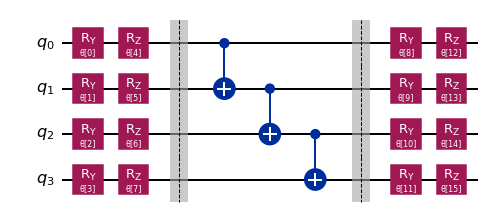

In [6]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True)
ansatz.draw('mpl', style='iqx')

# Define Optimizer and Initalize Parameters

In [7]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

# Define a Callback to Collect Intermediate Information

In [8]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

# Local Simulation

In [9]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

In [10]:
#Run the local VQE simulator
local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)

/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:620: UserWarning: Option max_credits is not used by this backend
  return backend.run(circuits, **backend_options, **noise_config, **run_config)


In [11]:
print('Eigenvalue:', local_result.eigenvalue)
print('Target:', target_energy)

Eigenvalue: -0.998046875
Target: -1.0


In [12]:
#print(local_result)

#intermediate_info['energy']

# Runtime VQE


In [36]:
# get backend
backend = provider.get_backend('ibmq_montreal')

In [37]:
# Reset callback

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [38]:
# Use error mitigation 
measurement_error_mitigation = True

In [39]:
#define VQE

from qiskit_nature.runtime import VQEProgram

# in this first release, the optimizer must be specified as dictionary
optimizer = {'name': 'SPSA',
             'maxiter': 50}

runtime_vqe = VQEProgram(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend,
                         shots=1024,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=callback)

In [40]:
runtime_result = runtime_vqe.compute_minimum_eigenvalue(hamiltonian)

runtime_job._start_websocket_client:WARNING:2021-07-08 11:58:33,347: An error occurred while streaming results from the server for job c3jhmv3ma37p8k0gngj0:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 289, in _start_websocket_client
    self._ws_client.job_results()
  File "/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/webs

In [41]:
print('Eigenvalue:', runtime_result.eigenvalue)
print('Target:', target_energy)

Eigenvalue: -0.981664174714544
Target: -1.0


In [42]:
print('Mean error:', np.mean(intermediate_info['stddev']))

Mean error: nan


/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
history = runtime_result.optimizer_history

loss = history['loss']
timestamps = history['time']

runtimes = np.concatenate(([0], np.diff(timestamps)))
runtimes_in_min = runtimes / 60

In [49]:
history.keys()

dict_keys(['loss', 'params', 'time'])

In [44]:
print(f'Total time taken: {np.sum(runtimes_in_min):.2f}min\n')

# note that the median and average might differ, since the device get's calibrated every hour
# resulting in some iteration times that are much larger than the rest
print(f'Median time of the iterations: {np.median(runtimes):.2f}s')
print(f'Average time per iteration: {np.mean(runtimes):.2f}s')
print(f'Standard deviation: {np.std(runtimes):.2f}s')

Total time taken: 26.19min

Median time of the iterations: 27.88s
Average time per iteration: 31.43s
Standard deviation: 12.17s


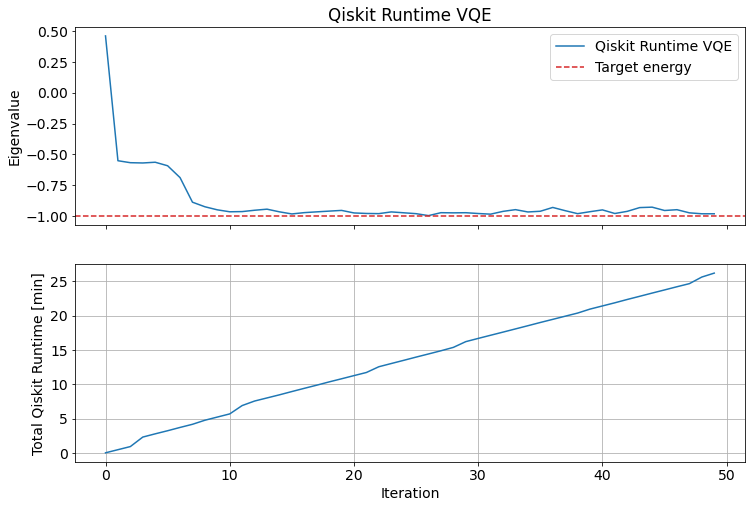

In [45]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))

# plot loss and reference value
ax1.plot(loss, label='Qiskit Runtime VQE')
ax1.axhline(y=target_energy, color='tab:red', ls='--', label='Target energy')

# plot time taken
ax2.plot(np.cumsum(runtimes_in_min))

# settings
ax1.set_title('Qiskit Runtime VQE')
ax1.set_ylabel('Eigenvalue')
ax1.legend(loc='best')
ax2.set_ylabel('Total Qiskit Runtime [min]')
ax2.set_xlabel('Iteration')
ax2.grid();

# Call VQE from the Cloud

In [21]:
# Collect inputs to VQE
vqe_inputs = {
    'ansatz': ansatz,
    'operator': hamiltonian,
    'optimizer': {'name': 'SPSA', 'maxiter': 5},  # let's only do a few iterations!
    'initial_point': initial_point,
    'measurement_error_mitigation': True,
    'shots': 1024
}

In [22]:
# Set the name of the backend
backend_options = {
    'backend_name': backend.name()
}

In [23]:
# Reset the callback

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def raw_callback(*args):
    job_id, (nfev, parameters, energy, stddev) = args
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [24]:
# run the job

job = provider.runtime.run(
    program_id='vqe',
    inputs=vqe_inputs,
    options=backend_options,
    callback=raw_callback
)
print('Job ID:', job.job_id())

Job ID: c3jhaepkjfmd50ohf1p0


In [27]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job is actively running

runtime_job._start_websocket_client:WARNING:2021-07-08 11:25:40,520: An error occurred while streaming results from the server for job c3jhaepkjfmd50ohf1p0:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 289, in _start_websocket_client
    self._ws_client.job_results()
  File "/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/webs

Job Status: job has successfully run


In [28]:
result = job.result()

In [29]:
print(f'Reached {result["optimal_value"]} after {result["optimizer_evals"]} evaluations.')

Reached -0.7804611726425335 after 16 evaluations.


In [30]:
print('Available keys:', list(result.keys()))

Available keys: ['optimizer_evals', 'optimizer_time', 'optimal_value', 'optimal_point', 'optimal_parameters', 'cost_function_evals', 'eigenstate', 'eigenvalue', 'aux_operator_eigenvalues', 'optimizer_history']


In [50]:
pwd

'/Users/stenger/Documents/Research/Hubbard_symmetries'